# Codebook measure

In this notebook, we compute the codebook as described in the WIFS paper on various different datasets

- Iphone Dataset run 1-6
- Samsung Dataset run 1-6

We compare both codebooks obtained on original and fakes.

## Libraries

In [2]:
import os

import numpy as np
from lib.Dataset_cdp import DatasetCDP
from lib.predictor_functions import batch_train_codebook
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import json

## Parameters

Define the parameters of the run

In [3]:
nb_samples = 500
processing = 'hist_matching'
run = 1
dataset = 'samsung' # 'iphone' or 'samsung'
seed = 0

use_unet = False

poolsize = 50


## Load dataset

In [5]:
assert dataset in {'iphone', 'samsung'}, print(f'{dataset} is not a valid choice of acquisition system !')
dset = DatasetCDP(dataset_name=dataset, run=run, nb_samples=1440, load_unet=use_unet, normalized=False, hist_match=True)


In [6]:
loader = DataLoader(dset, batch_size=len(dset), shuffle=False)
for data in loader:
    for key in data.keys():
        data[key] = np.asarray(data[key])

In [7]:
possible_choices = list(np.arange(len(dset)))

np.random.seed(seed)
random_perm = np.random.permutation(possible_choices)
print(random_perm[:20])

[ 308  152  875  503  351   18 1001 1095  995  933 1068  528    5 1140
 1064   45  465 1023  869  270]


In [8]:
for key in data.keys():
    data[key] = data[key][random_perm[:nb_samples]]

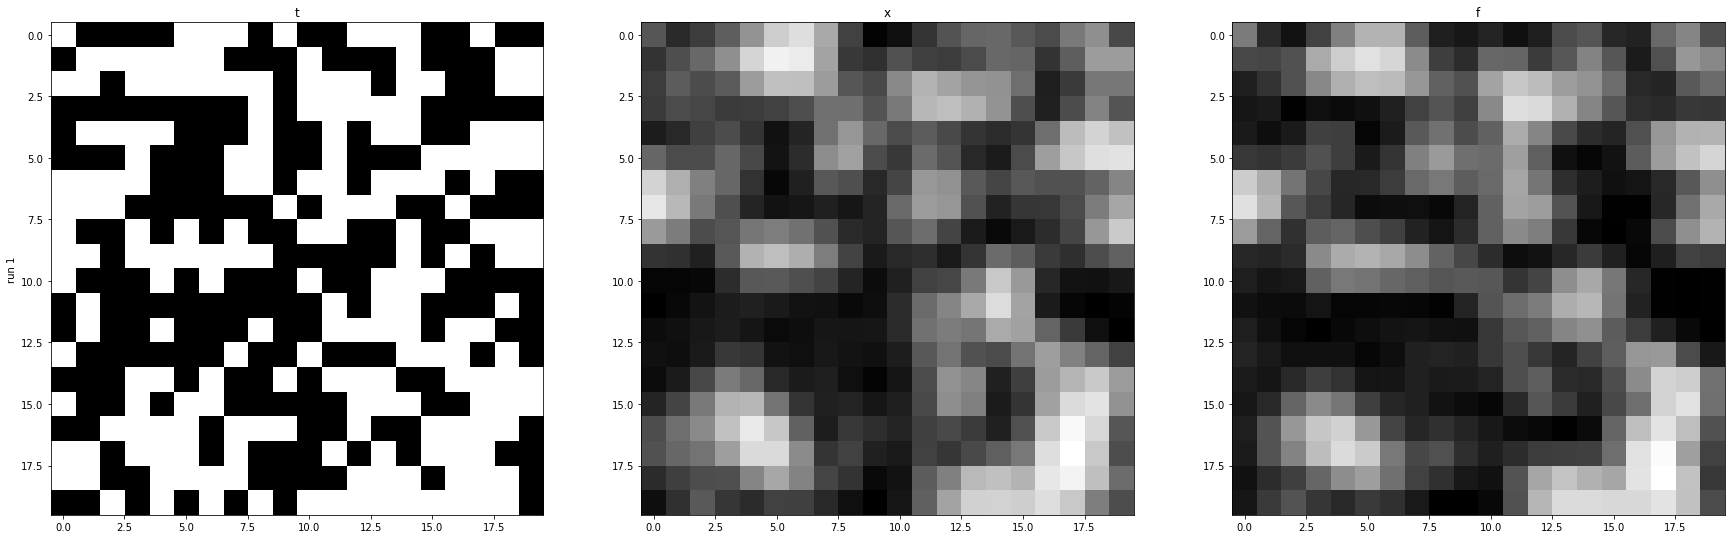

In [9]:
plt.figure(figsize=(30,30))

limit = 20
i = 1

for name in data.keys():
    plt.subplot(1,len(data.keys()), i)
    plt.imshow(data[name][0, limit:2*limit, limit:2*limit], cmap='gray')
    if i == 1:
        plt.ylabel(f'run {run}')
    plt.title(name)
    i += 1

plt.show()

## Train model

In [10]:
if use_unet:
    local_prob_x, _ = batch_train_codebook((data['t'] > 0.5), data['t_x'], poolsize=poolsize, block_size=1)
    local_prob_f, _ = batch_train_codebook((data['t'] > 0.5), data['t_f'], poolsize=poolsize, block_size=1)

else:
    local_prob_x, _ = batch_train_codebook((data['t'] > 0.5), data['x'], estimator='otsu', poolsize=poolsize, block_size=1)
    local_prob_f, _ = batch_train_codebook((data['t'] > 0.5), data['f'], estimator='otsu', poolsize=poolsize, block_size=1)

In [11]:
hist_x = []
hist_f = []

for i in range(512):
    code = bin(i)[2:].zfill(9)
    hist_x += [local_prob_x['error'][code]]
    hist_f += [local_prob_f['error'][code]]

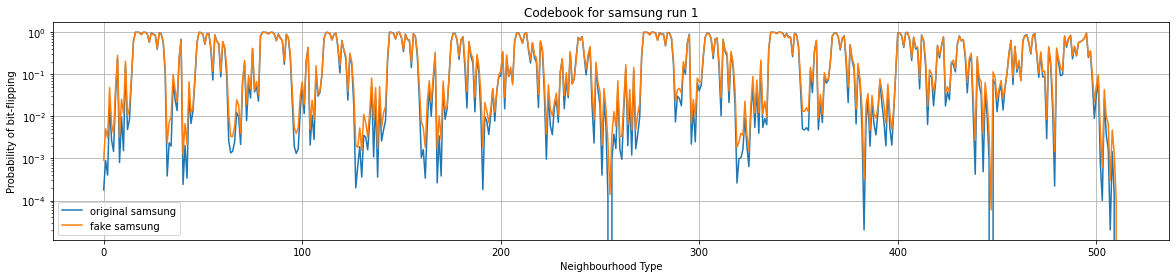

In [12]:
plt.figure(figsize=(20,4))
plt.title(f'Codebook for {dataset} run {run}')
plt.plot(hist_x, label=f'original {dataset}')
plt.plot(hist_f, label=f'fake {dataset}')
plt.yscale('log')
plt.xlabel('Neighbourhood Type')
plt.ylabel('Probability of bit-flipping')
plt.legend()
plt.grid()
plt.show()

In [13]:
if use_unet:
    with open(f'results/codebooks/codebook_measures/{dataset}_original_samples_{nb_samples}_run_{run}_seed_{seed}_unet.json', "w") as fp:
        json.dump(hist_x, fp)

    with open(f'results/codebooks/codebook_measures/{dataset}_fake_samples_{nb_samples}_run_{run}_seed_{seed}_unet.json', "w") as fp:
        json.dump(hist_f, fp)
else:
    with open(f'results/codebooks/codebook_measures/{dataset}_original_samples_{nb_samples}_run_{run}_seed_{seed}_otsu.json', "w") as fp:
        json.dump(hist_x, fp)

    with open(f'results/codebooks/codebook_measures/{dataset}_fake_samples_{nb_samples}_run_{run}_seed_{seed}_otsu.json', "w") as fp:
        json.dump(hist_f, fp)